# ___

# [ Machine Learning in Earth Observation and Geography ]

</br>

<div>
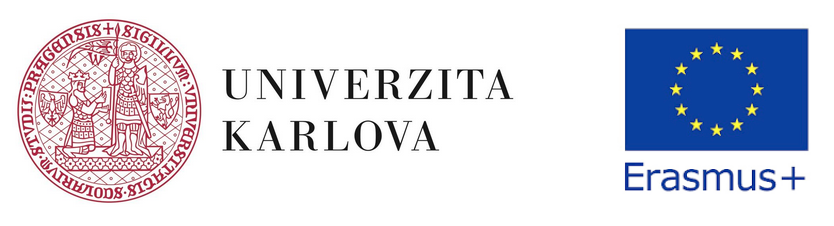
</div>

---

Lecturer: *Lukas Brodsky lukas.brodsky@natur.cuni.cz*

**Department of Applied Geoinformatics and Carthography, Charles University** 

___

## GeoPandas & Rasterio

This notebook demonstrates how to combine vectors and rasters in Python workflow. 

## Rasterizing poylgons

In [1]:
import os 
import geopandas as gpd 
import rasterio as rio
from rasterio import features
import numpy as np 

import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# Reading vector 
# CHANGE TO YOUR PATH!!!
path = '/Users/lukas/Work/prfuk/vyuka/erasmus_ml_geography/data/'
filename = 'polygons.shp'
path_fn_vec = os.path.join(path, filename)
gdf = gpd.read_file(path_fn_vec)

In [3]:
gdf.head()

,label,note,geometry
0,1,glacier,"POLYGON ((630019.737 7747367.105, 630896.053 7..."
1,2,debries,"POLYGON ((631944.079 7740883.553, 632169.079 7..."
2,3,rock,"POLYGON ((625330.263 7741517.105, 625780.263 7..."


In [4]:
geometry = gdf['geometry'] 

In [5]:
geometry

0    POLYGON ((630019.737 7747367.105, 630896.053 7...
1    POLYGON ((631944.079 7740883.553, 632169.079 7...
2    POLYGON ((625330.263 7741517.105, 625780.263 7...
Name: geometry, dtype: geometry

In [6]:
# Reading example raster 
raster_filename = 'landsat.tif' 
path_fn_ras = os.path.join(path, raster_filename)
ds = rio.open(path_fn_ras)
ds

<open DatasetReader name='/Users/lukas/Work/prfuk/vyuka/erasmus_ml_geography/data/landsat.tif' mode='r'>

In [7]:
# Raster file metadata 
meta = ds.meta
print(type(meta))
print('Metadata od the dataset: ...')
for k in meta:
    print(k, meta[k])

<class 'dict'>
Metadata od the dataset: ...
driver GTiff
dtype int16
nodata None
width 500
height 500
count 6
crs EPSG:32621
transform | 30.00, 0.00, 624000.00|
| 0.00,-30.00, 7750000.00|
| 0.00, 0.00, 1.00|


In [8]:
meta['width']

500

In [9]:
meta['count'] = 1

In [11]:
meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': None,
 'width': 500,
 'height': 500,
 'count': 1,
 'crs': CRS.from_epsg(32621),
 'transform': Affine(30.0, 0.0, 624000.0,
        0.0, -30.0, 7750000.0)}

In [10]:
# out filename 
out_fn_ras = os.path.join(path, 'rasterized_poly.tif')

In [12]:
# write the raster 
with rio.open(out_fn_ras, 'w+', **meta) as out:
    out_arr = out.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf.label))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)


In [15]:
os.path.isfile(out_fn_ras)

True

In [16]:
# Check the rasterization! 
rio_ds = rio.open(out_fn_ras)
rio_arr = rio_ds.read(1)
rio_arr.shape

(500, 500)

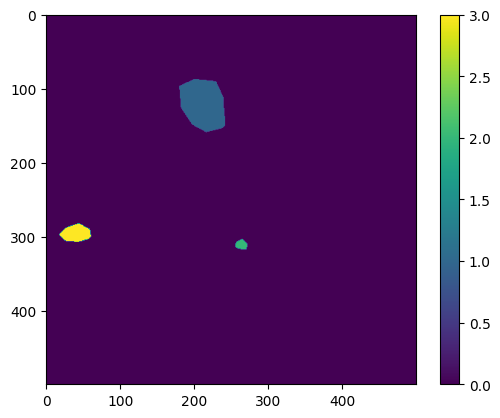

In [17]:
plt.imshow(rio_arr)
plt.colorbar()

In [18]:
np.unique(rio_arr)

array([0, 1, 2, 3], dtype=int16)

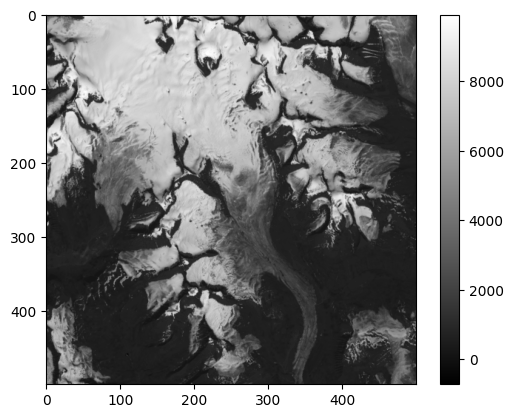

In [24]:
B1 = ds.read(1)
plt.imshow(B1, cmap='gray')
plt.colorbar()

### Raster Vector overlay 


In [25]:
# bands
ds.indexes

(1, 2, 3, 4, 5, 6)

In [26]:
image_arr = np.dstack([ds.read(b) for b in ds.indexes])

In [27]:
image_arr.shape

(500, 500, 6)

In [28]:
rio_arr.shape 

(500, 500)

In [35]:
image_arr.shape

(500, 500, 6)

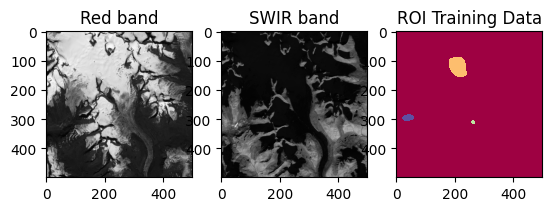

In [40]:
# Display them
plt.subplot(131)
plt.imshow(image_arr[:, :, 2], cmap=plt.cm.Greys_r)
plt.title('Red band')

plt.subplot(132)
plt.imshow(image_arr[:, :, 5], cmap=plt.cm.Greys_r)
plt.title('SWIR band')

plt.subplot(133)
plt.imshow(rio_arr, cmap=plt.cm.Spectral, interpolation='nearest')
plt.title('ROI Training Data')

plt.show()

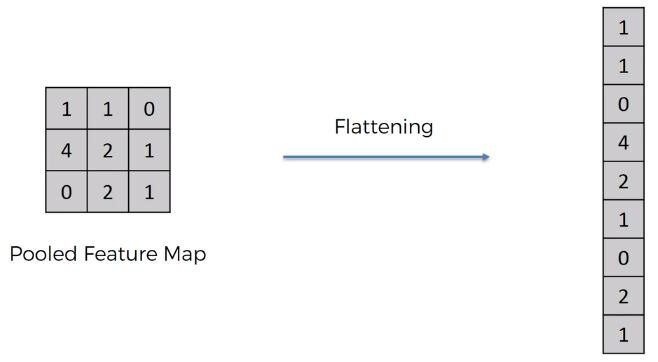

In [52]:
rio_arr.shape

(500, 500)

In [51]:
flattened_rio = rio_arr[rio_arr > 0]
flattened_rio.shape

(4370,)

In [56]:
image_arr[rio_arr > 0, :].shape

(4370, 6)

In [57]:
# my data for Machine Learning 
X = image_arr[rio_arr > 0, :] 
y = rio_arr[rio_arr > 0]

In [59]:
# X.shape

In [60]:
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

Our X matrix is sized: (4370, 6)
Our y array is sized: (4370,)


In [61]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 200 trees
rf = RandomForestClassifier(n_estimators=200, oob_score=True) 

# Fit our model to training data
rf = rf.fit(X, y)

In [63]:
# image_arr.shape

In [64]:
# Reshape from x*y array to colum-like vectors 
new_shape = (image_arr.shape[0] * image_arr.shape[1], image_arr.shape[2])


In [65]:
new_shape

(250000, 6)

In [66]:
image_arr.shape

(500, 500, 6)

In [67]:
img_as_array = image_arr.reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=image_arr.shape,
                                        n=img_as_array.shape))

Reshaped from (500, 500, 6) to (250000, 6)


In [68]:
# Now predict for each pixel
class_prediction = rf.predict(img_as_array)

In [70]:
np.unique(class_prediction)

array([1, 2, 3], dtype=int16)

In [71]:
class_prediction.shape

(250000,)

In [72]:
# Reshape our classification map
class_prediction = class_prediction.reshape(image_arr[:, :, 0].shape)

In [73]:
class_prediction.shape

(500, 500)

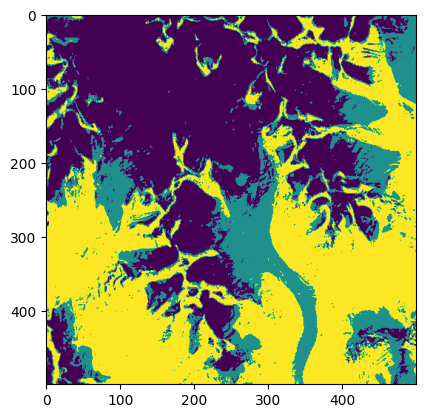

In [74]:
plt.imshow(class_prediction)

In [75]:
# Visualize
    
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),      # Nodata
    (1, (26, 222, 228, 255)), # Ice 
    (2, (16, 128, 132, 255)), # Debris
    (3, (200, 200, 200, 255)) # Bare 
))
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

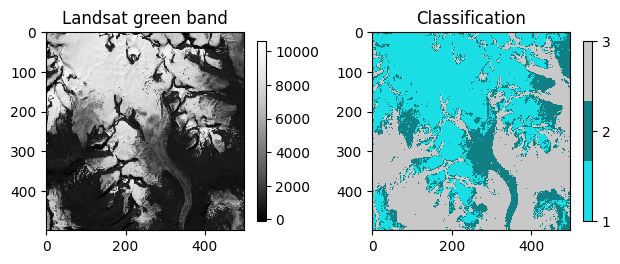

In [76]:
# Now show the classmap next to the image
plt.subplot(121)
plt.imshow(image_arr[:, :, 1], cmap=plt.cm.Greys_r, interpolation='none')
plt.colorbar(shrink=0.4)
plt.title('Landsat green band')
plt.subplot(122)
plt.imshow(class_prediction, cmap=cmap, interpolation='none')
plt.title('Classification')
#  ['ice', 'debris', 'bare']
plt.colorbar(cmap=cmap, ticks=np.unique(y), format='%1i', shrink=0.4)
plt.tight_layout()

In [ ]:
# Save the raster ... 